In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Concatenate, GaussianNoise, UpSampling2D, Conv2DTranspose, Conv2D, Dense, Lambda, Input, Flatten, Reshape, BatchNormalization, ReLU, LeakyReLU, MaxPooling2D
from tensorflow.keras.models import Model, load_model
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as K
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd



import os
import glob

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
import numpy as np
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


In [20]:
# network parameters
width = 64
height = 64
latent_dim = 100
inner_latent = 256
n_conds = 40


# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=(width,height,3), name='encoder_input')
condition = Input(shape=(n_conds,), name='encoder_condition')

x = GaussianNoise(1)(inputs) #Noise layer for denoising VAE
x = Conv2D(16, 3, strides=2, padding='same')(inputs)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = Conv2D(32, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = Conv2D(64, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = Conv2D(128, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)

(_,h,w,c) = x.shape

x = Flatten()(x)

x = Concatenate()([x,condition])

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model([inputs,condition], [z_mean, z_log_var, z, condition], name='encoder')
encoder.summary()



# # build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
decoder_condition = Input(shape=(n_conds,), name='decoder_condition')



x = Concatenate()([latent_inputs,decoder_condition])
x = Dense(h*w*c, activation='relu')(x)
x = Reshape((h,w,c))(x)
x = Conv2D(128,5, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = UpSampling2D()(x)
x = Conv2D(64,5, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = UpSampling2D()(x)
x = Conv2D(32,5, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = UpSampling2D()(x)
x = Conv2D(16,5, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = UpSampling2D()(x)

outputs = Conv2D(3,3, strides=1, activation='tanh', padding='same')(x)


# # instantiate decoder model
decoder = Model([latent_inputs,decoder_condition], outputs, name='decoder')
decoder.summary()

# # instantiate VAE model




outputs = decoder([encoder([inputs, condition])[2], encoder([inputs, condition])[3]])
vae = Model([inputs, condition], outputs, name='cnn_vae')
vae.summary()
history = []

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 32, 32, 16)   448         encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 32, 32, 16)   64          conv2d_18[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_16 (LeakyReLU)      (None, 32, 32, 16)   0           batch_normalization_16[0][0]     
____________________________________________________________________________________________

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: encoder_condition_2:0
Model: "cnn_vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
encoder_condition (InputLayer)  [(None, 40)]         0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 100), (None, 516200      encoder_input[0][0]              
                                                                 encoder_condition[0][0]          
                                                    

In [59]:
encoder([inputs, condition])[2]

<tf.Tensor 'encoder_11/Identity_2:0' shape=(None, 100) dtype=float32>

In [4]:
#Beta VAE warmup
from tensorflow.keras.callbacks import Callback
class Warmup(Callback):
    def __init__(self, beta, warmup_epoch):
        self.warmup_epoch = warmup_epoch
        self.beta = beta

    def on_epoch_end(self, epoch, logs={}):
        value = (epoch/self.warmup_epoch) * (epoch <= self.warmup_epoch) + 1.0 * (epoch > self.warmup_epoch)
        K.set_value(self.beta, value)
        print(f' epoch {epoch}, beta = {K.get_value(self.beta)}')

def vae_loss(y_true, y_pred):
    reconstruction_loss = mse(K.flatten(y_true), K.flatten(y_pred))
    reconstruction_loss *= width*height # common practice to scale with w*h
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    return K.mean(reconstruction_loss + kl_loss)
 
def vae_loss(y_true, y_pred):
    reconstruction_loss = mse(K.flatten(y_true), K.flatten(y_pred))
    reconstruction_loss *= width*height # common practice to scale with w*h
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    return K.mean(reconstruction_loss + kl_loss)
    
beta = K.variable(0.0)
def beta_vae_loss(y_true, y_pred):
    reconstruction_loss = mse(K.flatten(y_true), K.flatten(y_pred))
    reconstruction_loss *= width*height # common practice to scale with w*h
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    kl_loss * beta
    return K.mean(reconstruction_loss + kl_loss)




In [5]:
def normalize_for_tanh(img):
    return (img - 127.5) / 127.5

def unnormalize_tanh(img):
    return (img + 1) / 2

In [628]:
import cv2
import numpy as np
import glob 
import pandas as pd

def data_loader(file_path):
    img_paths = glob.glob(file_path + '/0*[0-9][0-9][0-9].jpg')
    data = []
    for img_path in img_paths:
        data.append(normalize_for_tanh(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)))
    return np.array(data)



X = data_loader('../celeba-clean-64/')
df = pd.read_csv('./celeba-attribs.csv')
c = df[list(df.columns[1:])].to_numpy()


In [629]:
X_c = X, c[:X.shape[0],:]

In [6]:
def encode_to_attribs(encoded):
    for present, attrib in zip(encoded, list(df.columns[1:])):
        if present == 1:
            print(attrib)

In [25]:
optimizer = Adam(0.0008)
vae.compile(optimizer=optimizer, loss=vae_loss, experimental_run_tf_function=False)
loss_curve = []

In [8]:
df = pd.read_csv('./celeba-attribs.csv')

In [19]:
training_data_generator = ImageDataGenerator(
    validation_split=0.0,
    horizontal_flip=False,
    preprocessing_function=normalize_for_tanh)


training_generator = training_data_generator.flow_from_dataframe(
    dataframe=df,
    directory='../celeba-clean-64/',
    x_col="img",
    y_col=list(df.columns[1:]),
    target_size=(64, 64),
    subset='training',
    shuffle=True,
    batch_size=202599,
    class_mode='raw')


Found 202599 validated image filenames.


In [21]:
training_data = training_generator.next()

In [22]:
len(training_imgs) // batch_size

3165

In [26]:
import time
epochs = 101
batch_size = 32

model_type = '200kimgs-cond'

training_imgs = training_data[0]
training_cond = training_data[1]
num_batches = len(training_imgs) // batch_size

for epoch in range(epochs):
    start = time.time()
    print(f'Epoch [{epoch}/{epochs-1}]...'.ljust(20), end = '')

    np.random.seed(epoch)
    np.random.shuffle(training_imgs)
    np.random.seed(epoch)
    np.random.shuffle(training_cond)
    
    loss = 0
    for index in range(num_batches):
        img_input = training_imgs[index*batch_size: batch_size*(index+1)]
        condition_input = training_cond[index*batch_size: batch_size*(index+1)]
        loss += vae.train_on_batch([img_input, condition_input], img_input)
    
    loss /= num_batches
    print(f'...{time.time()-start:.3f}(s) loss: {loss:.3f}')
    loss_curve.append(loss)
    if epoch % 100 == 0:
        print(f'checkpointing at epoch: {epoch}')
        decoder.save_weights(f'./checkpoints/epoch-{epoch}-{model_type}-decoder-weights.h5')
        decoder.save(f'./checkpoints/epoch-{epoch}-{model_type}-decoder.h5')
        encoder.save_weights(f'./checkpoints/epoch-{epoch}-{model_type}-encoder-weights.h5')
        encoder.save(f'./checkpoints/epoch-{epoch}-{model_type}-encoder.h5')


Epoch [0/100]...    ...130.973(s) loss: 349.255
checkpointing at epoch: 0
Epoch [1/100]...    ...128.769(s) loss: 291.790
Epoch [2/100]...    ...128.559(s) loss: 281.148
Epoch [3/100]...    ...128.584(s) loss: 275.675
Epoch [4/100]...    ...128.965(s) loss: 272.186
Epoch [5/100]...    ...128.552(s) loss: 269.686
Epoch [6/100]...    ...128.596(s) loss: 267.545
Epoch [7/100]...    ...128.708(s) loss: 265.875
Epoch [8/100]...    ...128.518(s) loss: 264.223
Epoch [9/100]...    ...128.431(s) loss: 262.780
Epoch [10/100]...   ...128.577(s) loss: 261.485
Epoch [11/100]...   ...128.595(s) loss: 260.551
Epoch [12/100]...   ...128.409(s) loss: 259.590
Epoch [13/100]...   ...128.380(s) loss: 258.956
Epoch [14/100]...   ...128.437(s) loss: 258.223
Epoch [15/100]...   ...128.422(s) loss: 257.692
Epoch [16/100]...   ...128.446(s) loss: 257.147
Epoch [17/100]...   ...128.395(s) loss: 256.652
Epoch [18/100]...   ...128.368(s) loss: 256.284
Epoch [19/100]...   ...128.384(s) loss: 255.855
Epoch [20/100]

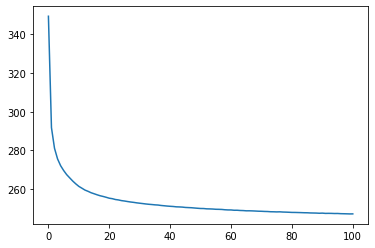

In [27]:
plt.plot(loss_curve)

In [635]:
val_imgs = X_c[0][15000:15010]
val_conds = X_c[1][15000:15010]

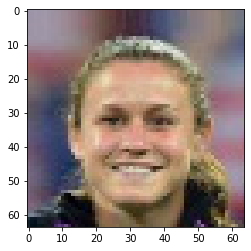

Bags_Under_Eyes
Brown_Hair
High_Cheekbones
Mouth_Slightly_Open
No_Beard
Oval_Face
Smiling
Straight_Hair
Young
None


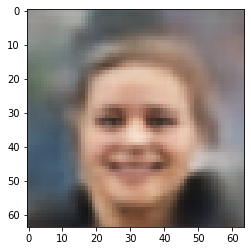

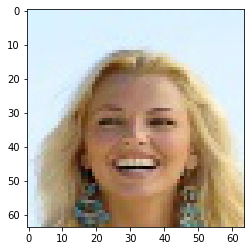

Arched_Eyebrows
Attractive
Big_Lips
Big_Nose
Blond_Hair
High_Cheekbones
Mouth_Slightly_Open
Narrow_Eyes
No_Beard
Smiling
Wavy_Hair
Wearing_Earrings
Wearing_Lipstick
Young
None


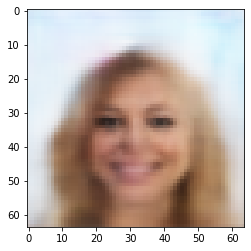

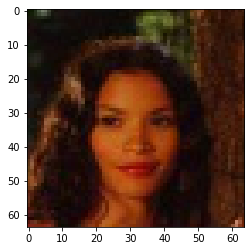

Attractive
Heavy_Makeup
No_Beard
Wavy_Hair
Wearing_Lipstick
Young
None


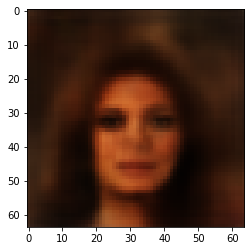

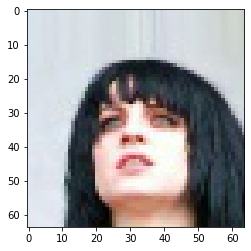

Bangs
Black_Hair
Heavy_Makeup
No_Beard
Pale_Skin
Straight_Hair
Young
None


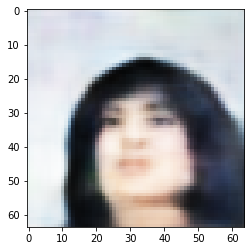

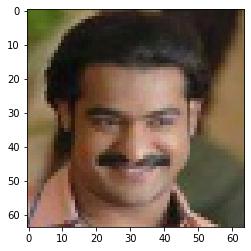

Black_Hair
Bushy_Eyebrows
High_Cheekbones
Male
Mouth_Slightly_Open
Mustache
Oval_Face
Smiling
Young
None


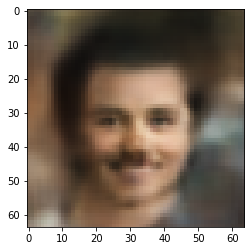

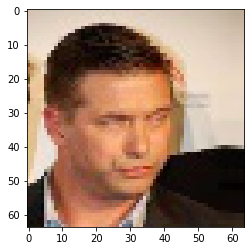

Black_Hair
Male
No_Beard
Oval_Face
Straight_Hair
Young
None


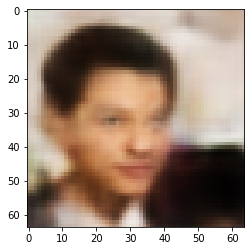

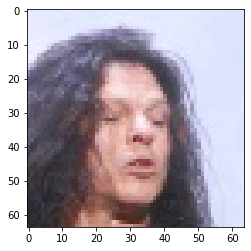

Blurry
Male
Narrow_Eyes
No_Beard
None


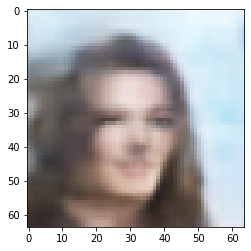

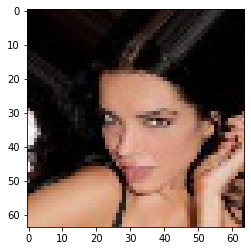

Attractive
Black_Hair
Heavy_Makeup
No_Beard
Pointy_Nose
Wearing_Lipstick
Young
None


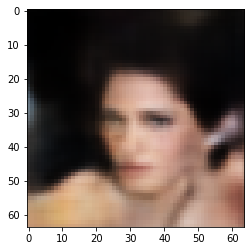

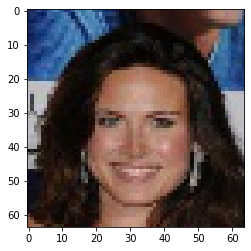

Arched_Eyebrows
Attractive
Big_Lips
Heavy_Makeup
High_Cheekbones
Mouth_Slightly_Open
No_Beard
Oval_Face
Pointy_Nose
Rosy_Cheeks
Smiling
Wavy_Hair
Wearing_Earrings
Wearing_Lipstick
Young
None


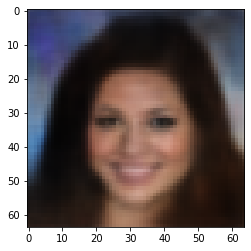

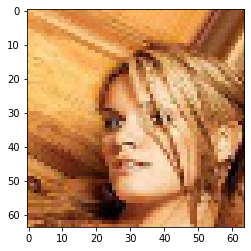

Attractive
Bangs
Blond_Hair
Mouth_Slightly_Open
No_Beard
Pointy_Nose
Wearing_Lipstick
Young
None


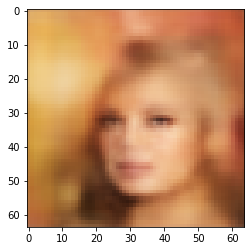

In [662]:
for image, cond in zip(val_imgs, val_conds):
    plt.imshow(unnormalize_tanh(image))
    plt.show()
    print(encode_to_attribs(cond))
    plt.imshow(unnormalize_tanh(vae.predict([np.array([image]),np.array([cond])])[0]))
    
    
    plt.show()

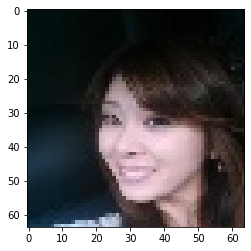

Attractive
Bags_Under_Eyes
Bangs
Big_Lips
Brown_Hair
High_Cheekbones
Mouth_Slightly_Open
No_Beard
Smiling
Wavy_Hair
Wearing_Earrings
Wearing_Lipstick
Young
None


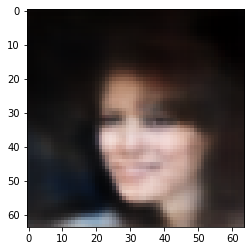

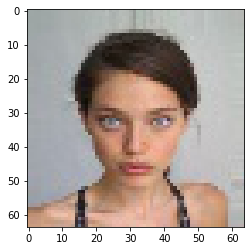

Attractive
Black_Hair
Heavy_Makeup
No_Beard
Oval_Face
Pointy_Nose
Wearing_Lipstick
Young
None


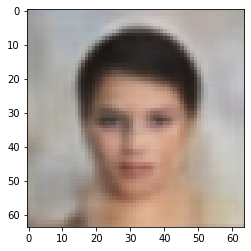

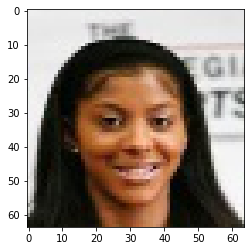

Arched_Eyebrows
Attractive
Black_Hair
High_Cheekbones
Mouth_Slightly_Open
No_Beard
Oval_Face
Smiling
Young
None


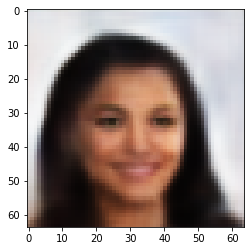

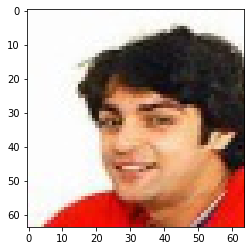

Big_Lips
Black_Hair
Blurry
Bushy_Eyebrows
High_Cheekbones
Male
Mouth_Slightly_Open
No_Beard
Smiling
Wavy_Hair
Young
None


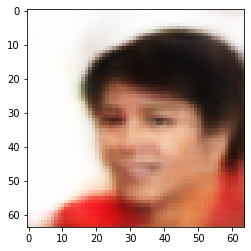

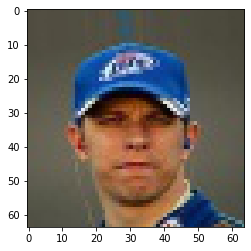

Male
Narrow_Eyes
No_Beard
Wearing_Hat
Young
None


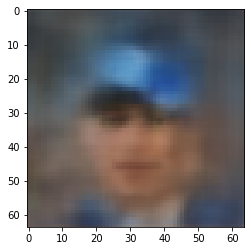

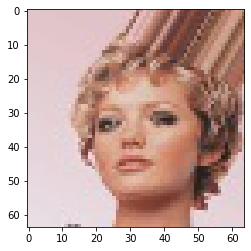

Arched_Eyebrows
Attractive
Heavy_Makeup
No_Beard
Pointy_Nose
Wavy_Hair
Wearing_Lipstick
Young
None


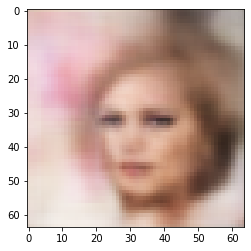

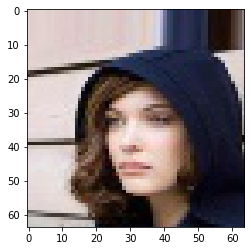

Big_Lips
Brown_Hair
Heavy_Makeup
No_Beard
Pointy_Nose
Wearing_Hat
Wearing_Lipstick
Young
None


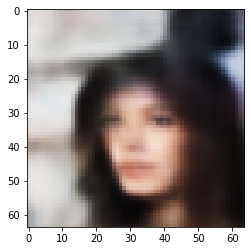

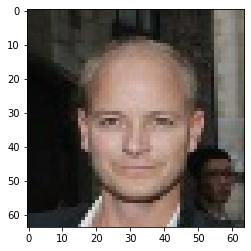

Bald
Male
No_Beard
Pointy_Nose
Receding_Hairline
None


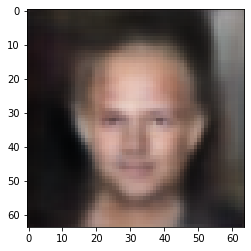

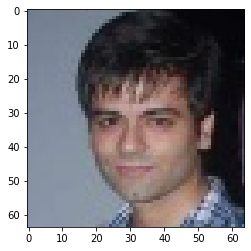

Black_Hair
Bushy_Eyebrows
High_Cheekbones
Male
No_Beard
Smiling
Straight_Hair
Young
None


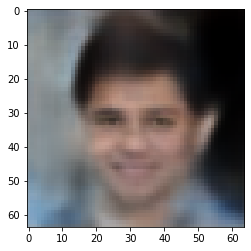

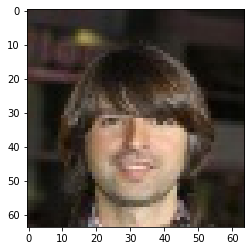

5_o_Clock_Shadow
Attractive
Bangs
Brown_Hair
Male
Mouth_Slightly_Open
No_Beard
Smiling
Straight_Hair
Young
None


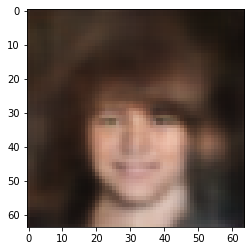

In [565]:
for image, cond in zip(val_imgs, val_conds):
    plt.imshow(image)
    plt.show()
    print(encode_to_attribs(cond))
    plt.imshow(vae.predict([np.array([image]),np.array([cond])])[0])
    
    
    plt.show()

In [50]:
import cv2
jose = cv2.cvtColor(cv2.imread("./test-jose.jpg"), cv2.COLOR_BGR2RGB) 

In [29]:
conditions_jose = None
@interact(five_o_Clock_Shadow=1, Arched_Eyebrows=1, Attractive=1, Bags_Under_Eyes=1, Bald=1, Bangs=1, Big_Lips=1, Big_Nose=1, Black_Hair=1, Blond_Hair=1, Blurry=1, Brown_Hair=1, Bushy_Eyebrows=1, Chubby=1, Double_Chin=1, Eyeglasses=1, Goatee=1, Gray_Hair=1, Heavy_Makeup=1, High_Cheekbones=1, Male=1, Mouth_Slightly_Open=1, Mustache=1, Narrow_Eyes=1, No_Beard=1, Oval_Face=1, Pale_Skin=1, Pointy_Nose=1, Receding_Hairline=1, Rosy_Cheeks=1, Sideburns=1, Smiling=1, Straight_Hair=1, Wavy_Hair=1, Wearing_Earrings=1, Wearing_Hat=1, Wearing_Lipstick=1, Wearing_Necklace=1, Wearing_Necktie=1, Young=1,)
def g(five_o_Clock_Shadow, Arched_Eyebrows, Attractive, Bags_Under_Eyes, Bald, Bangs, Big_Lips, Big_Nose, Black_Hair, Blond_Hair, Blurry, Brown_Hair, Bushy_Eyebrows, Chubby, Double_Chin, Eyeglasses, Goatee, Gray_Hair, Heavy_Makeup, High_Cheekbones, Male, Mouth_Slightly_Open, Mustache, Narrow_Eyes, No_Beard, Oval_Face, Pale_Skin, Pointy_Nose, Receding_Hairline, Rosy_Cheeks, Sideburns, Smiling, Straight_Hair, Wavy_Hair, Wearing_Earrings, Wearing_Hat, Wearing_Lipstick, Wearing_Necklace, Wearing_Necktie, Young):
    global conditions_jose
    conditions_jose = np.array([five_o_Clock_Shadow, Arched_Eyebrows, Attractive, Bags_Under_Eyes, Bald, Bangs, Big_Lips, Big_Nose, Black_Hair, Blond_Hair, Blurry, Brown_Hair, Bushy_Eyebrows, Chubby, Double_Chin, Eyeglasses, Goatee, Gray_Hair, Heavy_Makeup, High_Cheekbones, Male, Mouth_Slightly_Open, Mustache, Narrow_Eyes, No_Beard, Oval_Face, Pale_Skin, Pointy_Nose, Receding_Hairline, Rosy_Cheeks, Sideburns, Smiling, Straight_Hair, Wavy_Hair, Wearing_Earrings, Wearing_Hat, Wearing_Lipstick, Wearing_Necklace, Wearing_Necktie, Young])


NameError: name 'interact' is not defined

In [28]:

print(encode_to_attribs(conditions_jose))

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(121)
ax1.imshow(jose)
ax2 = fig.add_subplot(122)
ax2.imshow(unnormalize_tanh(vae.predict([np.array([normalize_for_tanh(jose)]),np.array([conditions_jose])])[0]))


plt.show()

NameError: name 'conditions_jose' is not defined

In [576]:
mu, sigma = 0, 1 #mean and standard deviation
s = np.random.normal(mu, sigma, latent_dim)
plt.imshow(decoder.predict([np.array([s]),np.array([conditions])])[0])
plt.show()

(40,)

In [30]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


In [429]:
print(f"=1, ".join(list(df.columns[1:])))

5_o_Clock_Shadow=1, Arched_Eyebrows=1, Attractive=1, Bags_Under_Eyes=1, Bald=1, Bangs=1, Big_Lips=1, Big_Nose=1, Black_Hair=1, Blond_Hair=1, Blurry=1, Brown_Hair=1, Bushy_Eyebrows=1, Chubby=1, Double_Chin=1, Eyeglasses=1, Goatee=1, Gray_Hair=1, Heavy_Makeup=1, High_Cheekbones=1, Male=1, Mouth_Slightly_Open=1, Mustache=1, Narrow_Eyes=1, No_Beard=1, Oval_Face=1, Pale_Skin=1, Pointy_Nose=1, Receding_Hairline=1, Rosy_Cheeks=1, Sideburns=1, Smiling=1, Straight_Hair=1, Wavy_Hair=1, Wearing_Earrings=1, Wearing_Hat=1, Wearing_Lipstick=1, Wearing_Necklace=1, Wearing_Necktie=1, Young


In [31]:
conditions = None
@interact(five_o_Clock_Shadow=1, Arched_Eyebrows=1, Attractive=1, Bags_Under_Eyes=1, Bald=1, Bangs=1, Big_Lips=1, Big_Nose=1, Black_Hair=1, Blond_Hair=1, Blurry=1, Brown_Hair=1, Bushy_Eyebrows=1, Chubby=1, Double_Chin=1, Eyeglasses=1, Goatee=1, Gray_Hair=1, Heavy_Makeup=1, High_Cheekbones=1, Male=1, Mouth_Slightly_Open=1, Mustache=1, Narrow_Eyes=1, No_Beard=1, Oval_Face=1, Pale_Skin=1, Pointy_Nose=1, Receding_Hairline=1, Rosy_Cheeks=1, Sideburns=1, Smiling=1, Straight_Hair=1, Wavy_Hair=1, Wearing_Earrings=1, Wearing_Hat=1, Wearing_Lipstick=1, Wearing_Necklace=1, Wearing_Necktie=1, Young=1,)
def g(five_o_Clock_Shadow, Arched_Eyebrows, Attractive, Bags_Under_Eyes, Bald, Bangs, Big_Lips, Big_Nose, Black_Hair, Blond_Hair, Blurry, Brown_Hair, Bushy_Eyebrows, Chubby, Double_Chin, Eyeglasses, Goatee, Gray_Hair, Heavy_Makeup, High_Cheekbones, Male, Mouth_Slightly_Open, Mustache, Narrow_Eyes, No_Beard, Oval_Face, Pale_Skin, Pointy_Nose, Receding_Hairline, Rosy_Cheeks, Sideburns, Smiling, Straight_Hair, Wavy_Hair, Wearing_Earrings, Wearing_Hat, Wearing_Lipstick, Wearing_Necklace, Wearing_Necktie, Young):
    global conditions
    conditions = np.array([five_o_Clock_Shadow, Arched_Eyebrows, Attractive, Bags_Under_Eyes, Bald, Bangs, Big_Lips, Big_Nose, Black_Hair, Blond_Hair, Blurry, Brown_Hair, Bushy_Eyebrows, Chubby, Double_Chin, Eyeglasses, Goatee, Gray_Hair, Heavy_Makeup, High_Cheekbones, Male, Mouth_Slightly_Open, Mustache, Narrow_Eyes, No_Beard, Oval_Face, Pale_Skin, Pointy_Nose, Receding_Hairline, Rosy_Cheeks, Sideburns, Smiling, Straight_Hair, Wavy_Hair, Wearing_Earrings, Wearing_Hat, Wearing_Lipstick, Wearing_Necklace, Wearing_Necktie, Young])


interactive(children=(IntSlider(value=1, description='five_o_Clock_Shadow', max=3, min=-1), IntSlider(value=1,…

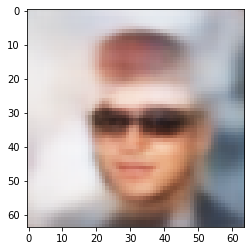

In [115]:
mu, sigma = 0, 1 #mean and standard deviation
#s = np.random.normal(mu, sigma,latent_dim)
plt.imshow(unnormalize_tanh( decoder.predict([np.array([s]),np.array([conditions])])[0]))
plt.show()